## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset

In [2]:
df = pd.read_excel('Customer_Churn_Dataset.xlsx')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,InternetService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,CUST-00001,Male,0,Yes,Yes,12,Yes,Fiber optic,One year,Mailed check,20.80,249.60,No
1,CUST-00002,Female,1,Yes,Yes,4,Yes,No,Month-to-month,Credit card,69.21,276.84,No
2,CUST-00003,Male,0,Yes,Yes,48,Yes,Fiber optic,Month-to-month,Bank transfer,73.14,3510.72,No
3,CUST-00004,Male,0,Yes,No,55,Yes,Fiber optic,Two year,Electronic check,40.13,2207.15,No
4,CUST-00005,Male,0,No,Yes,1,Yes,No,One year,Credit card,48.47,48.47,No


# Create SQL Database

In [3]:
conn = sqlite3.connect('customer_churn.db')
cursor = conn.cursor()

# Push data into SQL table

In [4]:
df.to_sql('customers', conn, if_exists='replace', index=False)

1500

# SQL Query – Check total customers & churn count

In [5]:
query_1 = """
SELECT 
    Churn,
    COUNT(*) AS total_customers
FROM customers
GROUP BY Churn;
"""
pd.read_sql(query_1, conn)

,Churn,total_customers
0,No,1447
1,Yes,53


# SQL Query – Contract type vs churn

In [6]:
query_2 = """
SELECT 
    Contract,
    COUNT(*) AS total_customers,
    SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) AS churned_customers
FROM customers
GROUP BY Contract;
"""
pd.read_sql(query_2, conn)

,Contract,total_customers,churned_customers
0,Month-to-month,827,53
1,One year,389,0
2,Two year,284,0


# SQL Query – Tenure impact on churn

In [7]:
query_3 = """
SELECT 
    Churn,
    AVG(tenure) AS avg_tenure
FROM customers
GROUP BY Churn;
"""
pd.read_sql(query_3, conn)

,Churn,avg_tenure
0,No,37.093988
1,Yes,6.358491


# SQL Query – Charges vs churn

In [8]:
query_4 = """
SELECT 
    Churn,
    AVG(MonthlyCharges) AS avg_monthly_charges,
    AVG(TotalCharges) AS avg_total_charges
FROM customers
GROUP BY Churn;
"""
pd.read_sql(query_4, conn)

,Churn,avg_monthly_charges,avg_total_charges
0,No,68.344540,2578.08452
1,Yes,92.518679,579.45434


# PYTHON PART (EDA + FEATURE ENGINEERING)

# Load data from SQL

In [9]:
df = pd.read_sql("SELECT * FROM customers", conn)

# Data cleaning

In [10]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.fillna(df.median(numeric_only=True), inplace=True)

# Exploratory Data Analysis (EDA)

# Churn distribution

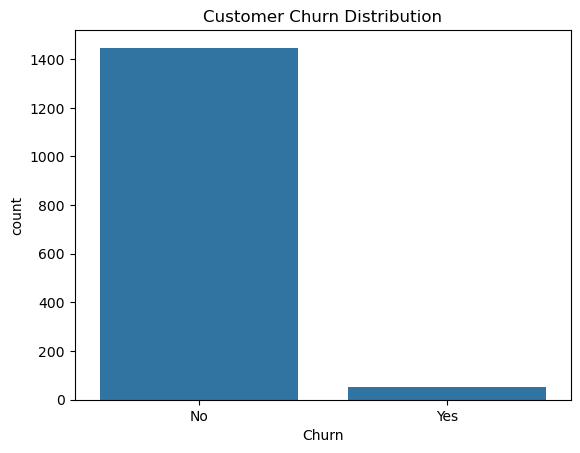

In [11]:
sns.countplot(x='Churn', data=df)
plt.title("Customer Churn Distribution")
plt.show()

# Contract vs Churn

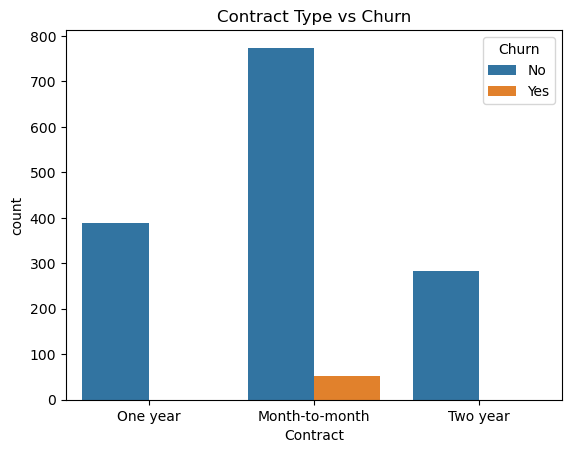

In [12]:
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title("Contract Type vs Churn")
plt.show()

# Encode categorical variables

In [13]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])

# AI / MACHINE LEARNING PART

# Split data

In [14]:
from sklearn.model_selection import train_test_split

X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train AI model (Random Forest)

In [15]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# Model evaluation

In [16]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9966666666666667
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       289
           1       1.00      0.91      0.95        11

    accuracy                           1.00       300
   macro avg       1.00      0.95      0.98       300
weighted avg       1.00      1.00      1.00       300



# Feature importance

In [17]:
importance = pd.Series(model.feature_importances_, index=X.columns)
importance.sort_values(ascending=False)

tenure             0.257289
MonthlyCharges     0.247146
TotalCharges       0.205739
Contract           0.157921
customerID         0.059687
PaymentMethod      0.022291
InternetService    0.013104
Partner            0.010501
gender             0.009400
Dependents         0.008604
PhoneService       0.005288
SeniorCitizen      0.003029
dtype: float64